In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from ours_eval import csls_knn_10_score, evaluation, separate_eva
from icp import ICPTrainer
import matplotlib.pyplot as plt
import utils
from utils import sub_icp, find_clts, find_centers, csls_knn_10_score
import params
import sklearn.cluster
from sklearn.decomposition import PCA

In [2]:
def normalize(x):
    return x / np.linalg.norm(x, ord=2, axis=1, keepdims=True)

In [3]:
src_id2word, src_word2id, src_embeddings = utils.read_txt_embeddings('data/wiki.%s.vec' % params.src_lang, params.n_eval_ex, False) #n_eval_ex = 200000
tgt_id2word, tgt_word2id, tgt_embeddings = utils.read_txt_embeddings('data/wiki.%s.vec' % params.tgt_lang, params.n_eval_ex, False)
src_normed = src_embeddings / np.linalg.norm(src_embeddings, ord=2, axis=1, keepdims=True)
tgt_normed = tgt_embeddings / np.linalg.norm(tgt_embeddings, ord=2, axis=1, keepdims=True)
cross_dict_src2tgt = utils.load_dictionary('data/%s-%s.5000-6500.txt' % (params.src_lang, params.tgt_lang), src_word2id, tgt_word2id)
cross_dict_tgt2src = utils.load_dictionary('data/%s-%s.5000-6500.txt' % (params.tgt_lang, params.src_lang), tgt_word2id, src_word2id)

Loaded 200000 pre-trained word embeddings.
Loaded 200000 pre-trained word embeddings.
data/en-es.5000-6500.txt
Found 2975 pairs of words in the dictionary (1500 unique). 0 other pairs contained at least one unknown word (0 in lang1, 0 in lang2)
data/es-en.5000-6500.txt
Found 2416 pairs of words in the dictionary (1500 unique). 0 other pairs contained at least one unknown word (0 in lang1, 0 in lang2)


In [4]:
T = np.load("%s/%s_%s_T.npy" % (params.cp_dir, params.src_lang, params.tgt_lang))
TranslatedX = src_embeddings.dot(np.transpose(T))

In [5]:
src_full = np.load("data/%s_%d.npy" % (params.src_lang, params.n_init_ex)) # 5000, 5000 english
tgt_full = np.load("data/%s_%d.npy" % (params.tgt_lang, params.n_init_ex)) # 300, 5000 es

# for i in range(5):
#src_full_normed = src_full / np.linalg.norm(src_full, ord=2, axis=1, keepdims=True)
#tgt_full_normed = tgt_full / np.linalg.norm(tgt_full, ord=2, axis=1, keepdims=True)
pca_25 = PCA(n_components = 25)
pca_25.fit(src_full)
src_W = pca_25.transform(src_full)
pca_25.fit(tgt_full)
tgt_W = pca_25.transform(tgt_full)

In [10]:
n_clusters = 2
src_km = sklearn.cluster.KMeans(n_clusters=n_clusters, n_init= 40, random_state=200)
tgt_km = sklearn.cluster.KMeans(n_clusters=n_clusters, n_init= 40, random_state=200)
src_y = src_km.fit_predict(src_full)
tgt_y = tgt_km.fit_predict(tgt_full)


In [11]:
dic = {}
for i in src_y:
    if i in dic.keys():
        dic[i] += 1
    else:
        dic[i] = 1
src_dic = sorted(dic.items(), key=operator.itemgetter(1), reverse = True)
print(src_dic)
src_centers = []
for i in range(n_clusters):
    idx = src_y == src_dic[i][0]
    src_centers.append(np.mean(src_full[idx], axis = 0))

dic = {}
for i in tgt_y:
    if i in dic.keys():
        dic[i] += 1
    else:
        dic[i] = 1
tgt_dic = sorted(dic.items(), key=operator.itemgetter(1), reverse = True)
print(tgt_dic)
tgt_centers = []
for i in range(n_clusters):
    idx = tgt_y == tgt_dic[i][0]
    tgt_centers.append(np.mean(tgt_full[idx], axis = 0))
src_centers = np.asarray(src_centers)
tgt_centers = np.asarray(tgt_centers)
src_centers.shape

[(0, 4931), (1, 69)]
[(1, 4838), (0, 162)]


(2, 300)

In [12]:
T_global = np.load("%s/%s_%s_T.npy" % (params.cp_dir, params.src_lang, params.tgt_lang))
Translated_centers = src_centers.dot(np.transpose(T_global))

In [13]:
trans_c = Translated_centers / np.linalg.norm(Translated_centers, ord=2, axis=1, keepdims=True)
tgt_c = tgt_centers / np.linalg.norm(tgt_centers, ord=2, axis=1, keepdims=True)
#trans_c = Translated_centers
#tgt_c = tgt_centers
cos_dis = trans_c.dot(tgt_c.T)
print(cos_dis)

[[0.94131481 0.55650728]
 [0.46917172 0.87170902]]


In [10]:
mk_dic = {0:3, 1:1, 2:0, 3:2, 4:4}

In [11]:
src_idx = src_y == src_dic[0][0]
src_1 = src_full[src_idx][:2500,:]
print(src_1.shape)
tgt_idx = tgt_y == tgt_dic[0][0]
tgt_1 = tgt_full[tgt_idx][:2500,:]
TX, TY = sub_icp(src_1.T, tgt_1.T, 20)

(2500, 300)
0: Rec 7.051579 BB 581 Time: 13.854957
1: Rec 7.279449 BB 569 Time: 12.862449
2: Rec 7.233799 BB 574 Time: 13.087926
3: Rec 7.087849 BB 599 Time: 13.216244
4: Rec 7.131791 BB 571 Time: 13.209556
5: Rec 7.229601 BB 549 Time: 13.711615
6: Rec 7.091916 BB 551 Time: 13.412582
7: Rec 7.267929 BB 526 Time: 13.516302
8: Rec 7.126434 BB 593 Time: 13.563968
9: Rec 6.994334 BB 570 Time: 13.767787
10: Rec 7.099142 BB 584 Time: 13.611411
11: Rec 7.128007 BB 504 Time: 13.677410
12: Rec 7.157099 BB 565 Time: 13.709306
13: Rec 7.020200 BB 550 Time: 13.718774
14: Rec 7.018141 BB 579 Time: 13.537457
15: Rec 7.232880 BB 544 Time: 13.604403
16: Rec 7.014908 BB 597 Time: 13.778265
17: Rec 7.126729 BB 601 Time: 13.755908
18: Rec 7.275681 BB 555 Time: 13.769253
19: Rec 7.019986 BB 562 Time: 13.658796
Init - Achieved: Rec 6.994334 BB 570
Training - Achieved: Rec 10.368324 BB 1044


In [12]:
cross_dict_src2tgt = utils.load_dictionary('data/%s-%s.5000-6500.txt' % (params.src_lang, params.tgt_lang), src_word2id, tgt_word2id)
cross_dict_tgt2src = utils.load_dictionary('data/%s-%s.5000-6500.txt' % (params.tgt_lang, params.src_lang), tgt_word2id, src_word2id)

data/en-es.5000-6500.txt
Found 2975 pairs of words in the dictionary (1500 unique). 0 other pairs contained at least one unknown word (0 in lang1, 0 in lang2)
data/es-en.5000-6500.txt
Found 2416 pairs of words in the dictionary (1500 unique). 0 other pairs contained at least one unknown word (0 in lang1, 0 in lang2)


In [13]:
def find_clts(data, centers, dico):
    s2t_s = data[dico[:,0],:]
    s2t_s = np.repeat(s2t_s[:, np.newaxis, :], centers.shape[0], axis = 1)
    diff = s2t_s - src_centers
    dist = np.linalg.norm(diff, ord=2, axis=2)
    classes = dist.argmin(axis = 1)
    return classes

In [14]:
classes = find_clts(data = src_embeddings, centers = src_centers, dico = cross_dict_src2tgt)
classes.shape

(2975,)

In [15]:
class_0 = classes[classes==0]
src_idx = np.where(classes==0)
tgt_idx = cross_dict_src2tgt[src_idx,1]
dico_0 = cross_dict_src2tgt[classes==0]
Translated_0 = src_embeddings.dot(np.transpose(TX))
print(class_0.shape)

(1875,)


In [16]:
from utils import get_nn_avg_dist
def csls_knn_10_score(emb_trans, emb_tgt, dico):
    emb_trans = emb_trans / np.linalg.norm(emb_trans, ord=2, axis=1, keepdims=True)
    emb_tgt = emb_tgt / np.linalg.norm(emb_tgt, ord=2, axis=1, keepdims=True)
    emb_trans = emb_trans.astype('float32')
    emb_tgt = emb_tgt.astype('float32')
    # I use csls_knn_10 directly
    average_dist1 = get_nn_avg_dist(emb = emb_tgt, query = emb_trans, knn = 10) #(200000,)
    average_dist2 = get_nn_avg_dist(emb = emb_trans, query = emb_tgt, knn = 10) #(200000,)
    
    query = emb_trans[dico[:, 0]] # dico[:, 0] is from source Domain, # dico[:, 1] is from target domain
    scores = 2 * query.dot(emb_tgt.T) #2975*200000
    scores -= average_dist1[dico[:, 0]][:, None] # right hand side: 2975, 1
    scores -= average_dist2[None,:] # right hand side: 1, 200000
    
    return scores

In [17]:
scores = csls_knn_10_score(emb_trans=Translated_0, emb_tgt=tgt_embeddings, dico=dico_0)
evaluation(scores, dico_0)

1012 source words -   - Precision at k = 1: 0.000000
1012 source words -   - Precision at k = 5: 0.000000
1012 source words -   - Precision at k = 10: 0.000000


[('precision_at_1', 0.0), ('precision_at_5', 0.0), ('precision_at_10', 0.0)]

In [32]:
# original - baseline
TranslatedX = src_embeddings.dot(np.transpose(TX))
scores = csls_knn_10_score(emb_trans=TranslatedX, emb_tgt=tgt_embeddings, dico=dico_0)
evaluation(scores, dico_0)

586 source words -   - Precision at k = 1: 80.887372
586 source words -   - Precision at k = 5: 91.296928
586 source words -   - Precision at k = 10: 93.174061


[('precision_at_1', 80.88737201365188),
 ('precision_at_5', 91.29692832764505),
 ('precision_at_10', 93.1740614334471)]

In [27]:
scores.shape

(1091, 200000)

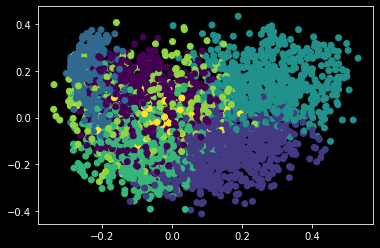

In [15]:
pca_2 = PCA(n_components = 2)
pca_2.fit(src_full_normed)
src_x = pca_2.transform(src_full_normed)
pca_2.fit(tgt_full_normed)
tgt_x = pca_2.transform(tgt_full_normed)
plt.scatter(src_x[:, 0], src_x[:, 1], c=src_y)